In [1]:
%matplotlib inline

In [26]:
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
from ipywidgets import interactive
from ipykernel.pylab.backend_inline import flush_figures

In [3]:
data = pd.read_csv("../data/train.csv", na_values=[-1, -1.0], index_col="id")

In [4]:
X, y = data.loc[:, data.columns != "target"], data.target

### Introduction

### Inspect columns and types

In [5]:
dict(zip(X.columns, X.dtypes))

{'ps_calc_01': dtype('float64'),
 'ps_calc_02': dtype('float64'),
 'ps_calc_03': dtype('float64'),
 'ps_calc_04': dtype('int64'),
 'ps_calc_05': dtype('int64'),
 'ps_calc_06': dtype('int64'),
 'ps_calc_07': dtype('int64'),
 'ps_calc_08': dtype('int64'),
 'ps_calc_09': dtype('int64'),
 'ps_calc_10': dtype('int64'),
 'ps_calc_11': dtype('int64'),
 'ps_calc_12': dtype('int64'),
 'ps_calc_13': dtype('int64'),
 'ps_calc_14': dtype('int64'),
 'ps_calc_15_bin': dtype('int64'),
 'ps_calc_16_bin': dtype('int64'),
 'ps_calc_17_bin': dtype('int64'),
 'ps_calc_18_bin': dtype('int64'),
 'ps_calc_19_bin': dtype('int64'),
 'ps_calc_20_bin': dtype('int64'),
 'ps_car_01_cat': dtype('float64'),
 'ps_car_02_cat': dtype('float64'),
 'ps_car_03_cat': dtype('float64'),
 'ps_car_04_cat': dtype('int64'),
 'ps_car_05_cat': dtype('float64'),
 'ps_car_06_cat': dtype('int64'),
 'ps_car_07_cat': dtype('float64'),
 'ps_car_08_cat': dtype('int64'),
 'ps_car_09_cat': dtype('float64'),
 'ps_car_10_cat': dtype('int64')

In [6]:
X.dtypes.value_counts()

int64      37
float64    20
dtype: int64

In [7]:
cat_cols = X.columns[X.columns.str.endswith("cat")].values.tolist()
bin_cols = X.columns[X.columns.str.endswith("bin")].values.tolist()
other = X.loc[:, ~X.columns.isin(cat_cols + bin_cols)]
int_cols = other.columns[other.dtypes == "int64"].values.tolist()
float_cols = other.columns[other.dtypes == "float64"].values.tolist()
numeric_cols = int_cols + float_cols

In [8]:
ordered_cols = cat_cols + float_cols + bin_cols + int_cols
X = X.loc[:, ordered_cols]
data = X.join(y)

There are values of two types (float and int), but variables have different meanings: categorical or numeric

### Features distributions

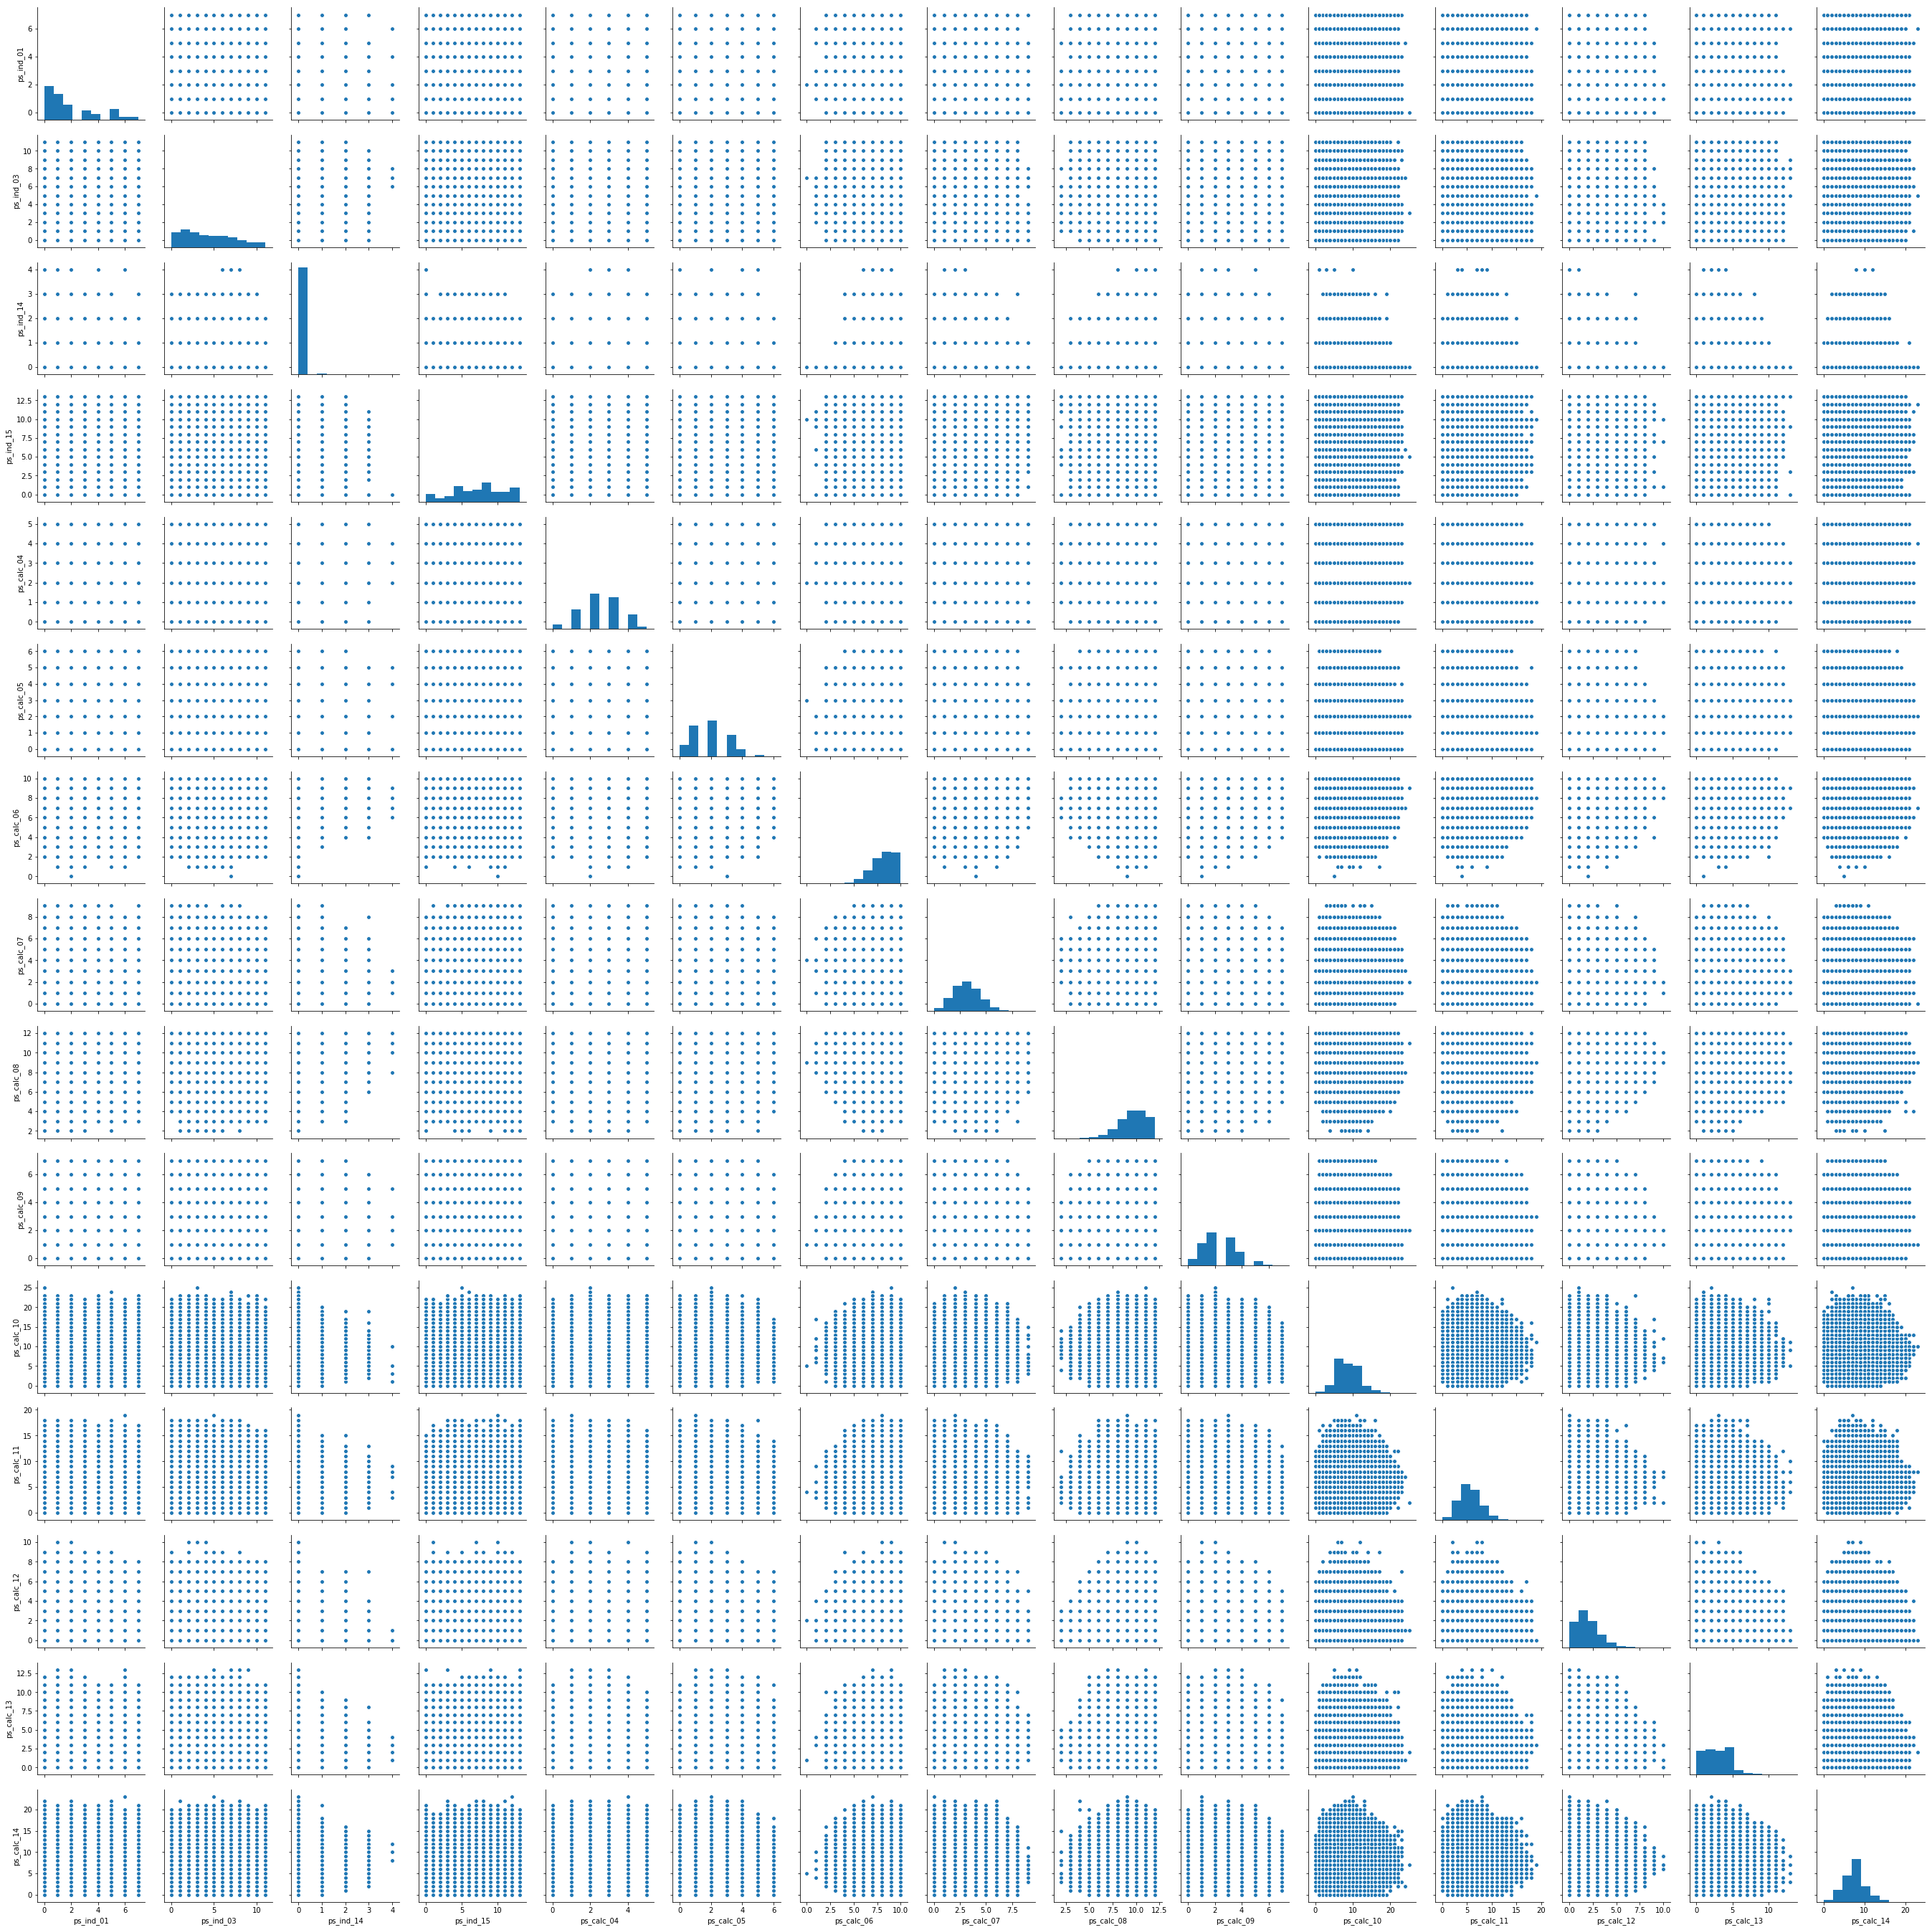

In [57]:
sns.pairplot(X.loc[:, int_cols])

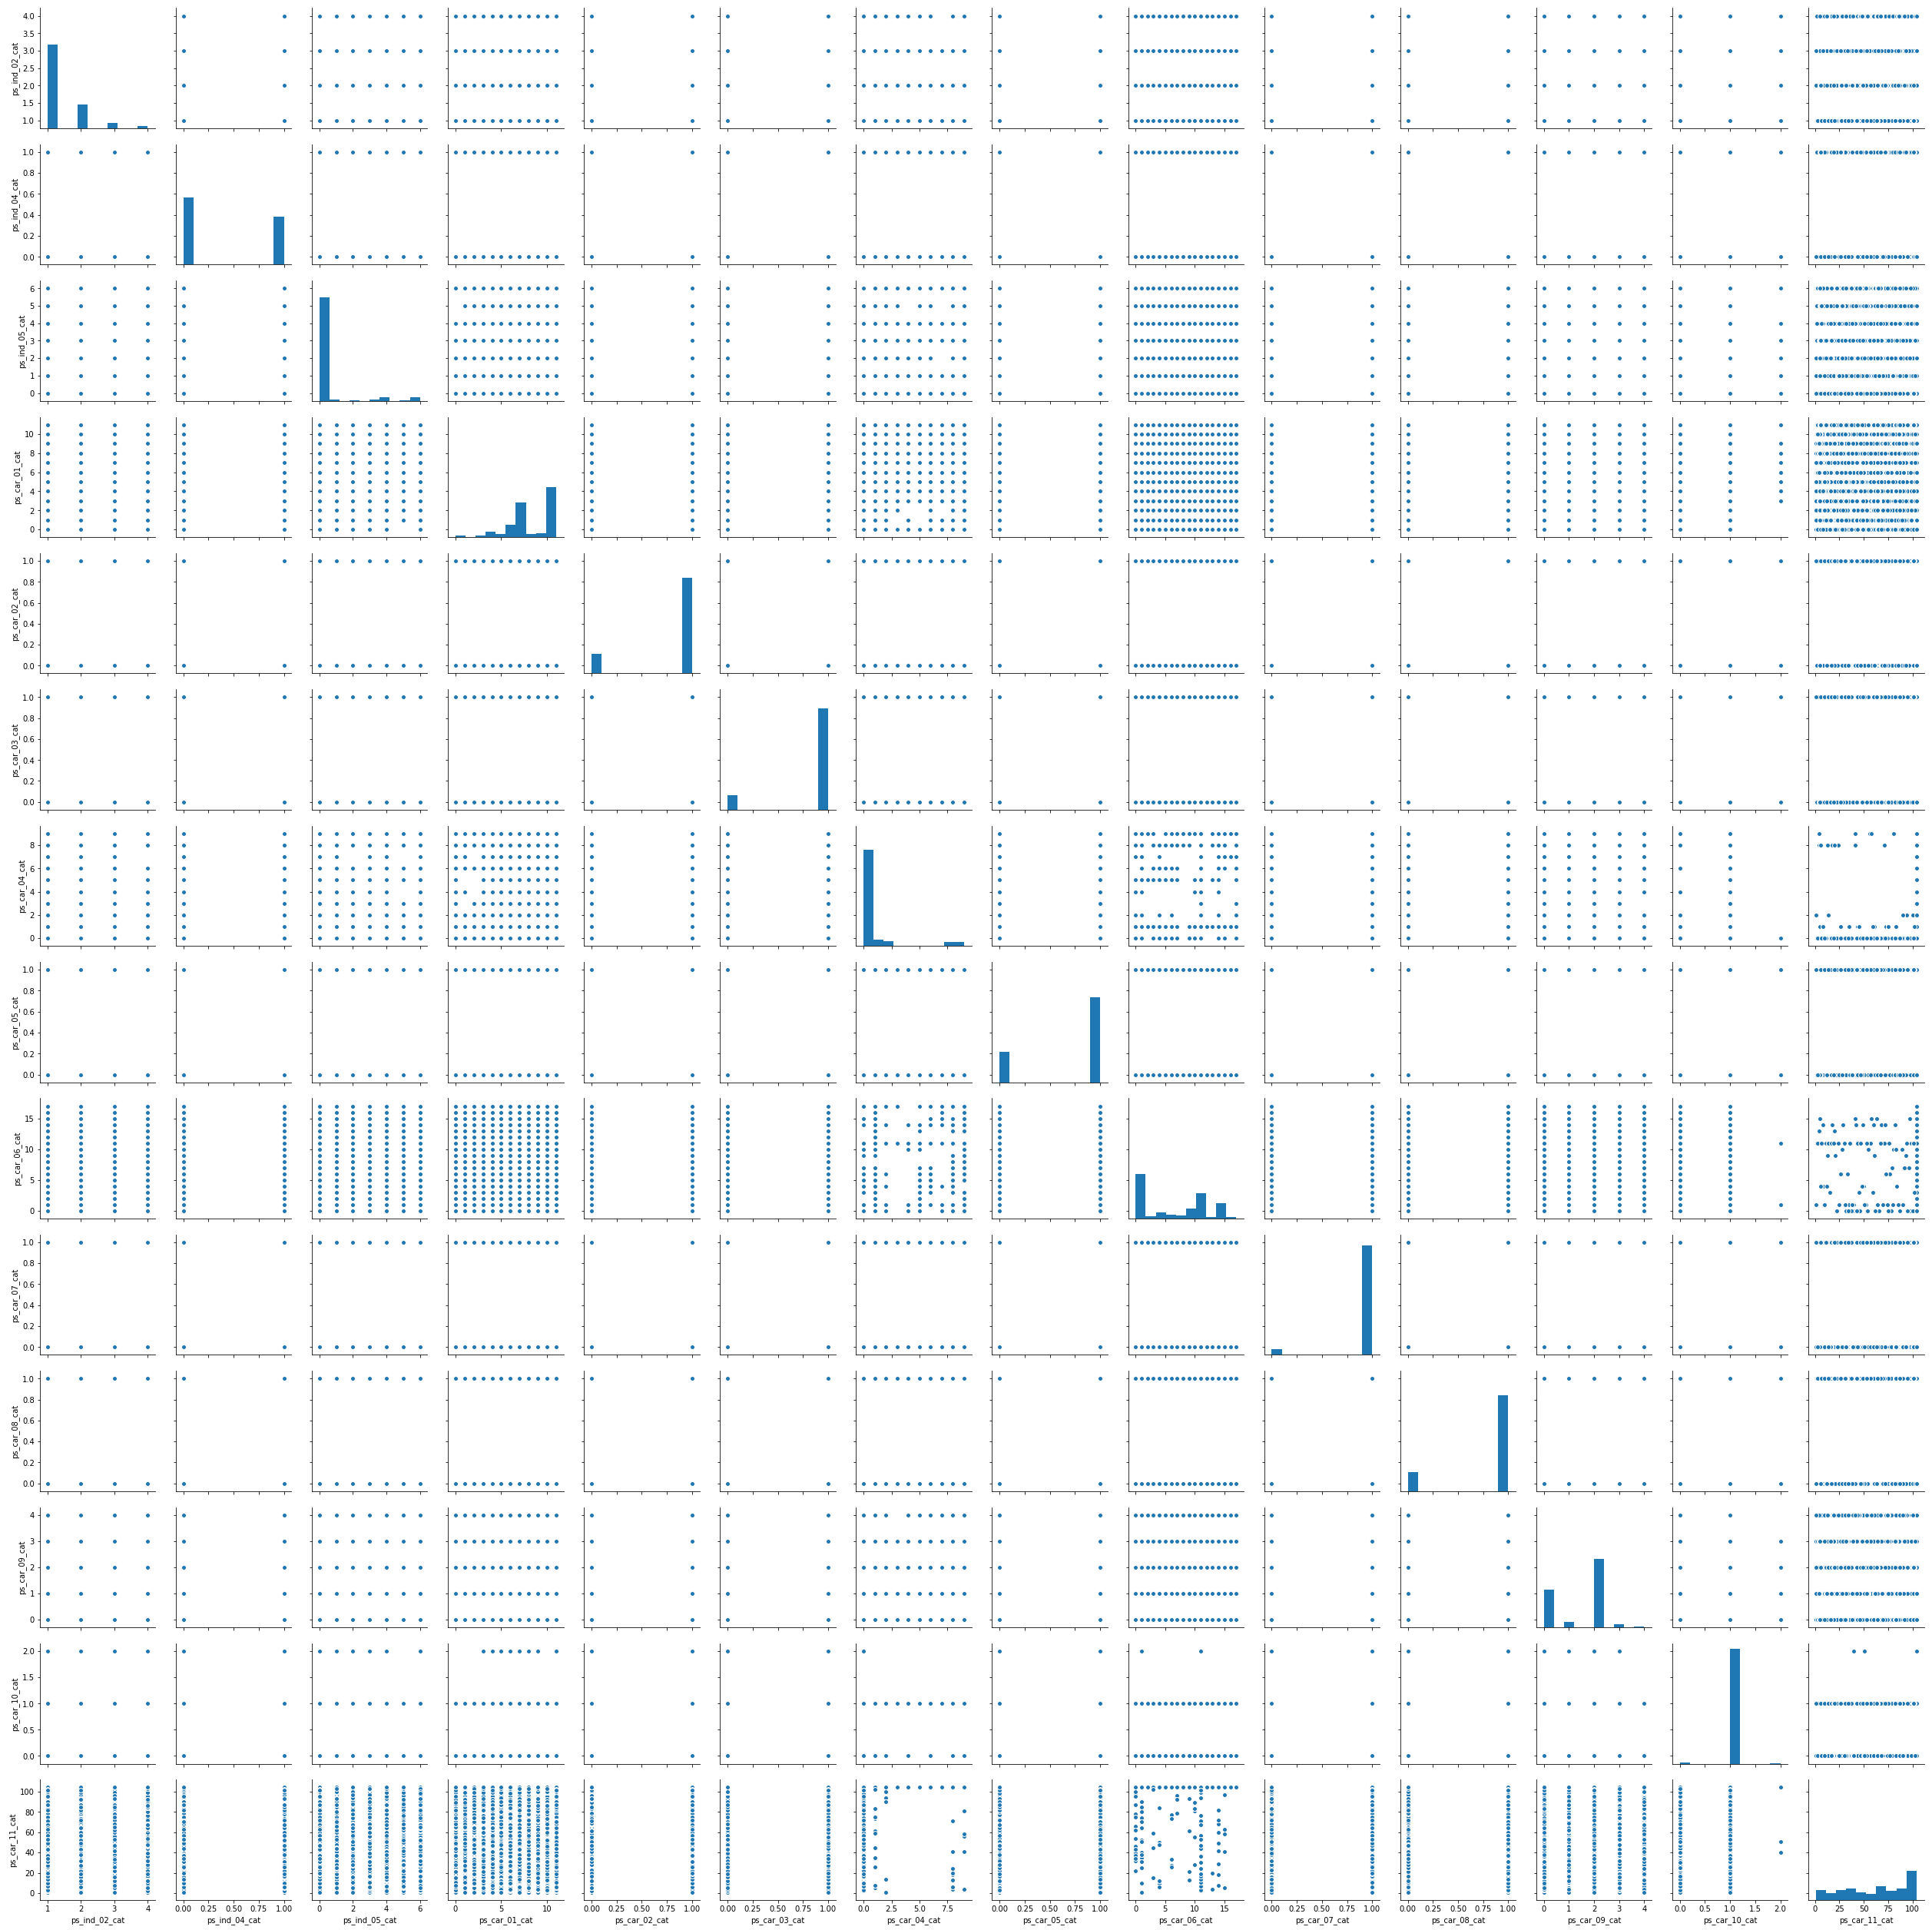

In [ ]:
sns.pairplot(X.loc[:, cat_cols].fillna(X.loc[:, cat_cols].median()))

In [ ]:
g = sns.PairGrid(X.loc[:, float_cols].fillna(X.loc[:, float_cols].median()))
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, cmap="Blues_d", n_levels=6);

/usr/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


### Missing values 

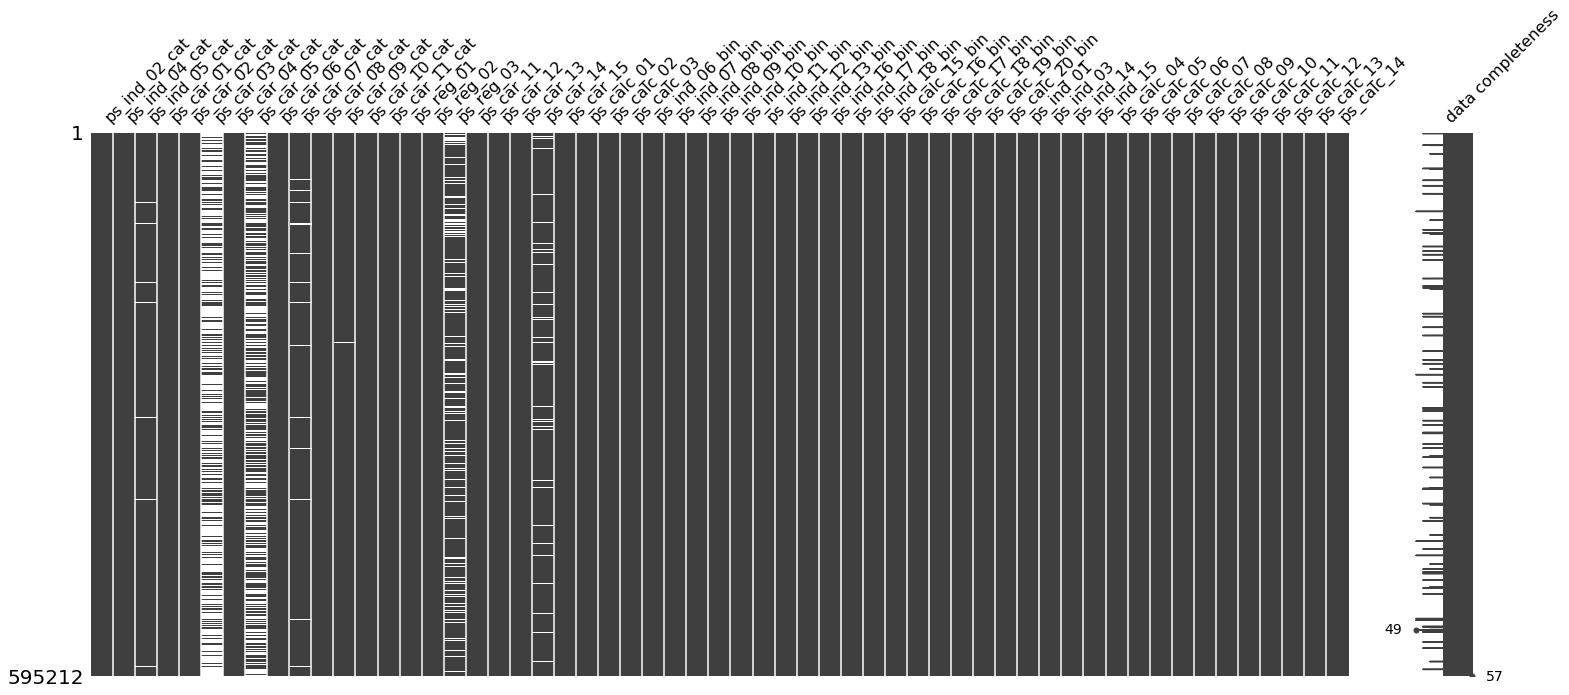

In [50]:
msno.matrix(X, labels=True)

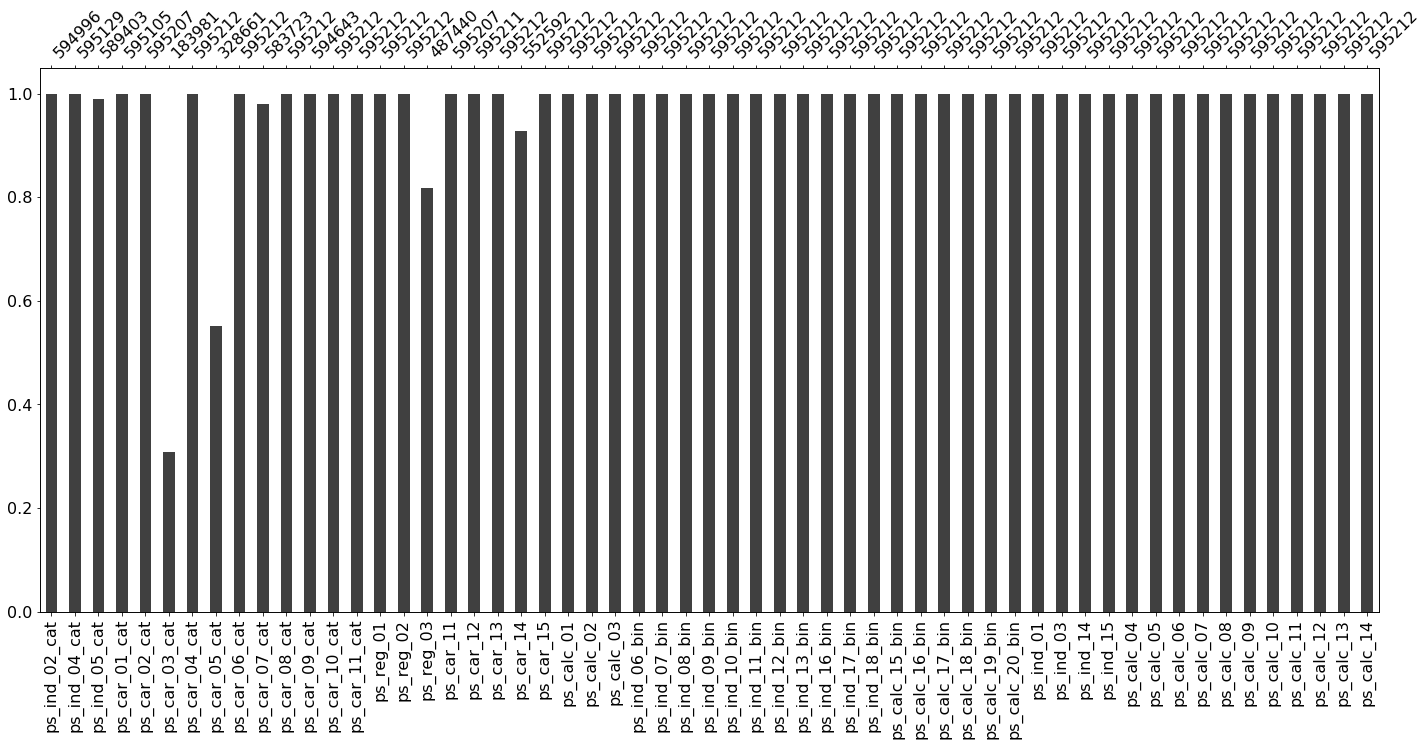

In [51]:
msno.bar(X)

In [54]:
X.columns[X.isnull().any()]

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_05_cat', 'ps_car_07_cat',
       'ps_car_09_cat', 'ps_reg_03', 'ps_car_11', 'ps_car_12', 'ps_car_14'],
      dtype='object')

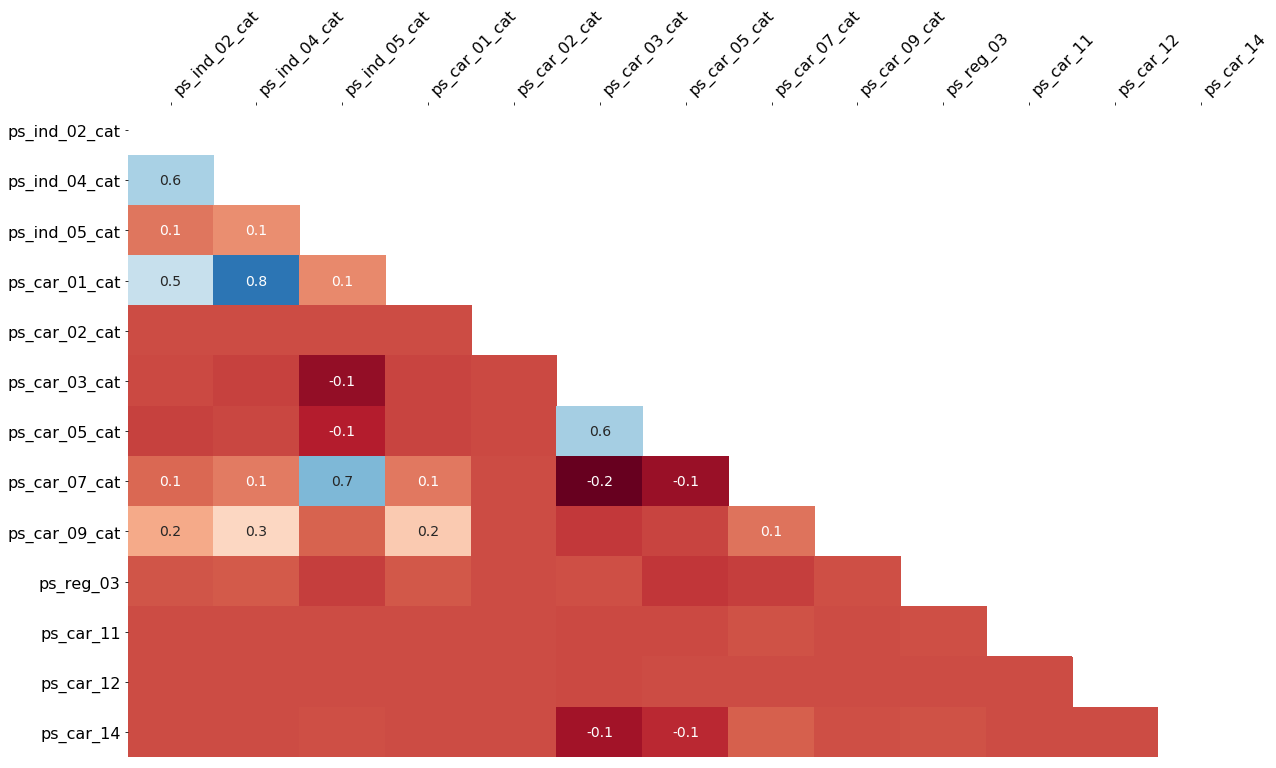

In [52]:
msno.heatmap(X)

There are missing values only in some variables, and always variables that are float or categorical (not int or binary). No sample has a particularly distinct amount of missing values.

### Targets distributions 

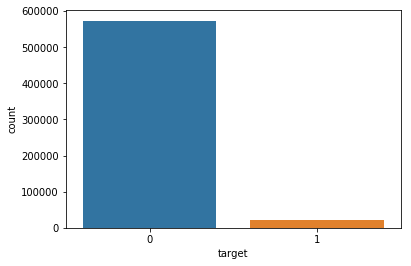

In [24]:
sns.countplot(y)

The target distribution is very unbalanced, which means that we're going to need some way to deal with this problem (over or undersampling)

### Joint distributions

In [78]:
def categories_barplot(df, ax):
    try:
        df.drop("target", axis=1).plot.bar(x="value", stacked=True, ax=ax)
    except:
        print(df.drop("target", axis=1))
        raise

#### Numeric Columns 

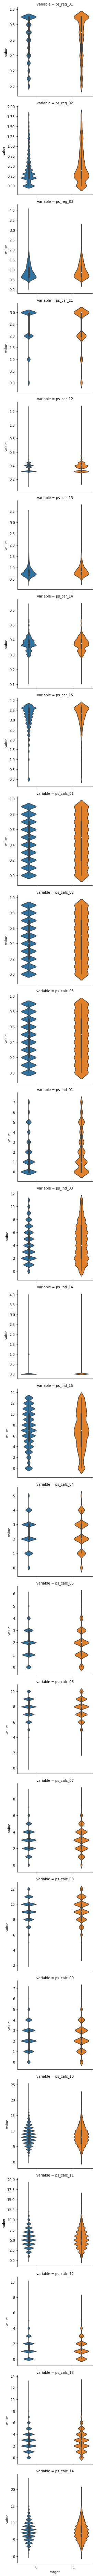

In [9]:
float_values = pd.melt(data, value_vars=float_cols + int_cols, id_vars="target")
sns.factorplot(data=float_values, x="target", y="value", hue="target", row="variable", kind="violin", sharey=False)

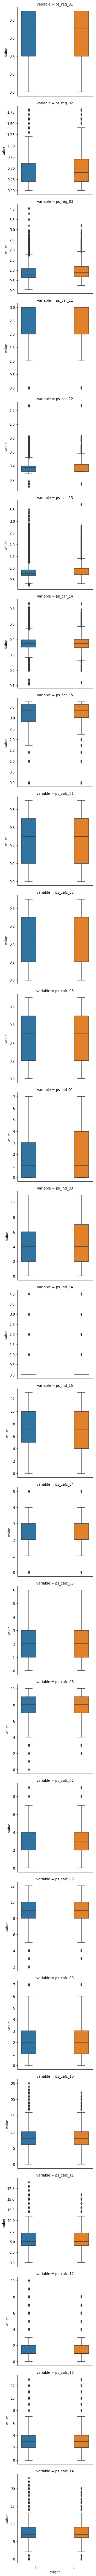

In [79]:
float_values = pd.melt(data, value_vars=float_cols + int_cols, id_vars="target")
sns.factorplot(data=float_values, x="target", y="value", hue="target", row="variable", kind="box", sharey=False)

#### Categorical columns

In [64]:
cat_values = pd.melt(data, value_vars=cat_cols, id_vars="target")
cat_values = cat_values.groupby(["variable", "value"]).agg({"target": "mean"}).reset_index()
cat_values["ones"] = cat_values.target
cat_values["zeros"] = 1 - cat_values.target

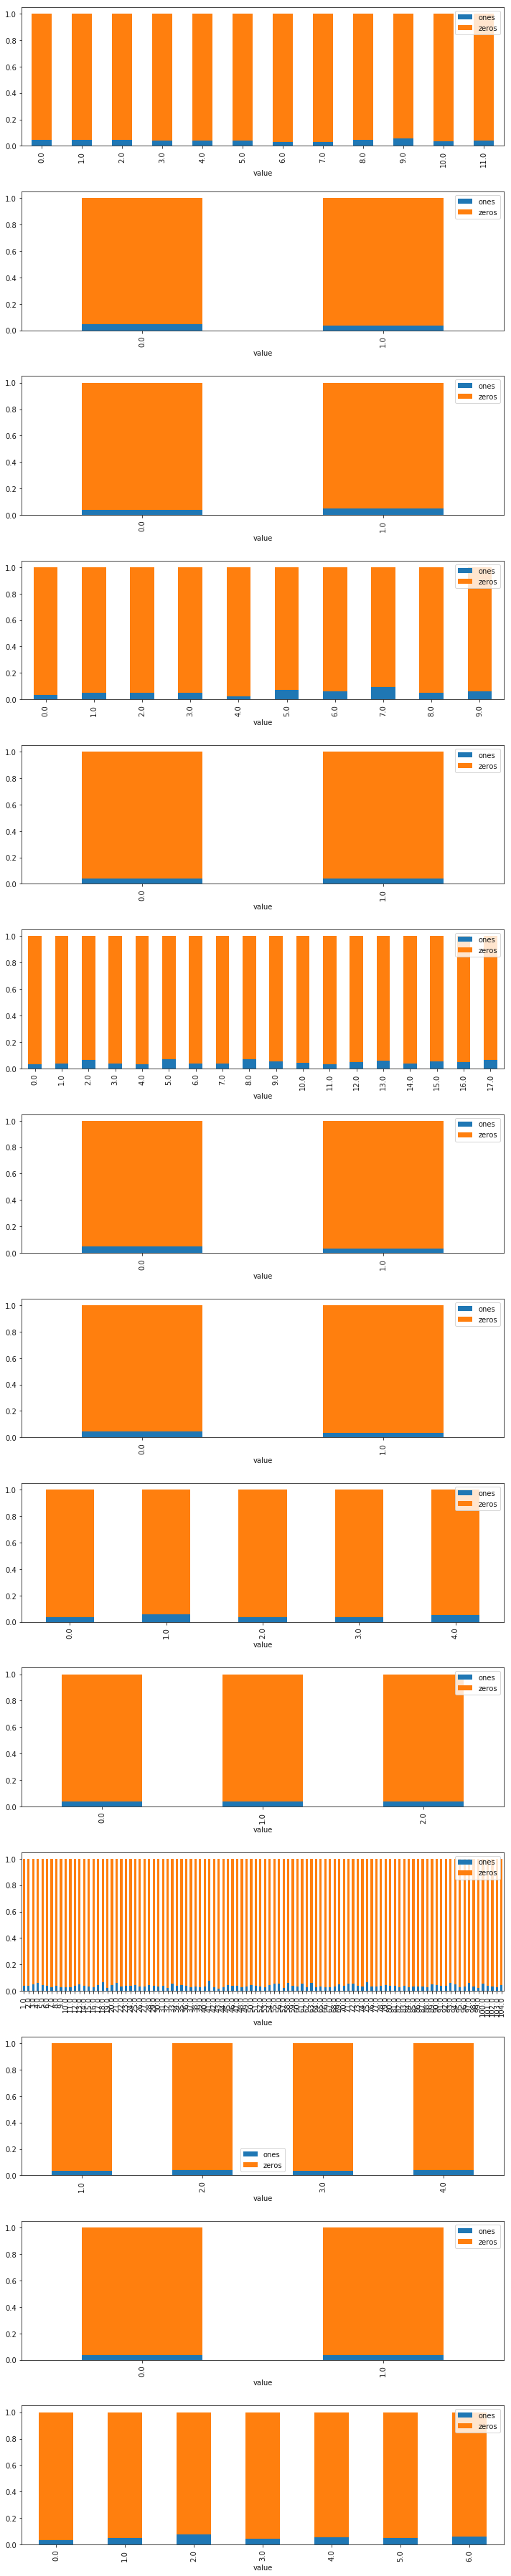

In [65]:
fig, axs = plt.subplots(cat_values.variable.nunique(), 1, figsize=(10, 50))
for ax, (var, df) in zip(axs, cat_values.groupby("variable")):
    categories_barplot(df, ax)
fig.tight_layout()

#### Binary columns

In [83]:
bin_values = pd.melt(data, value_vars=bin_cols, id_vars="target")
bin_values = bin_values.groupby(["variable", "value"]).agg({"target": "mean"}).reset_index()
bin_values["ones"] = bin_values.target
bin_values["zeros"] = 1 - bin_values.target

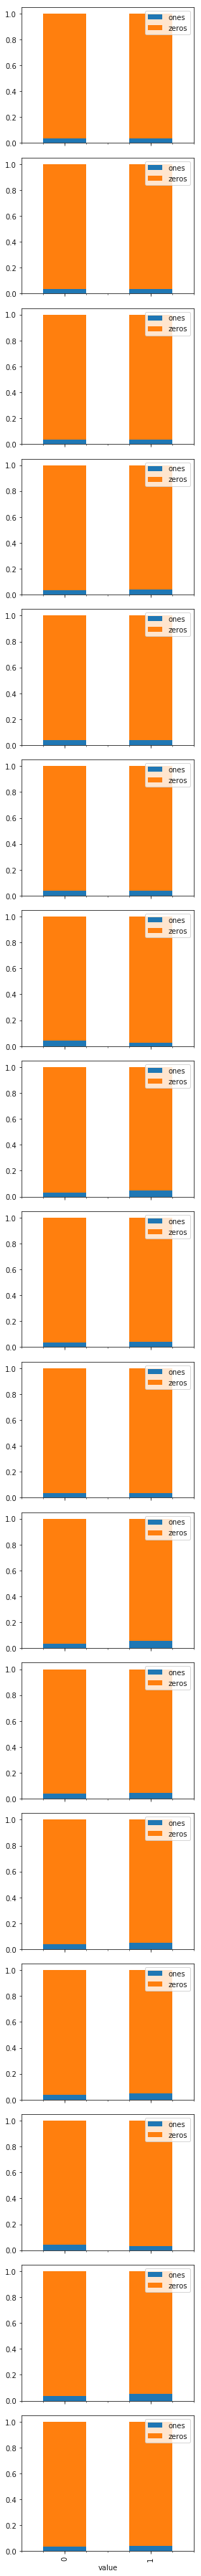

In [86]:
fig, axs = plt.subplots(bin_values.variable.nunique(), 1, figsize=(4, 50), sharex=True)
for ax, (var, df) in zip(axs, bin_values.groupby("variable")):
    categories_barplot(df, ax)
fig.tight_layout()

### Correlations

In [89]:
corr = data.loc[:, float_cols + int_cols + ["target"]].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

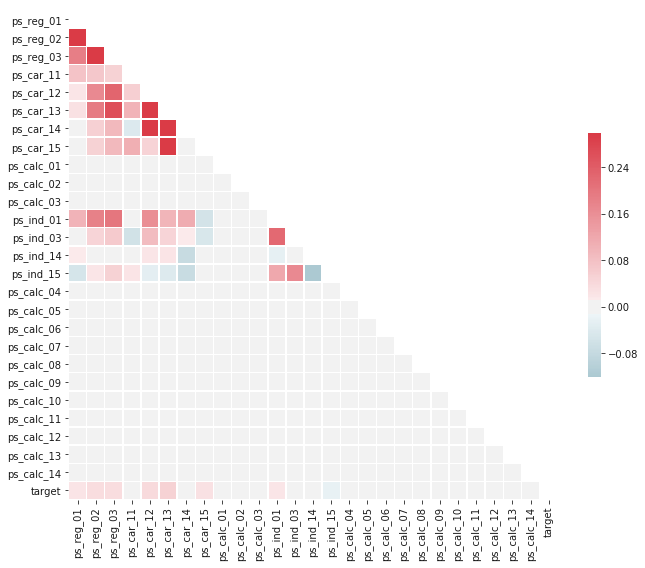

In [90]:
fig, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [28]:
numeric_cols = pd.Series(numeric_cols)

@interact(group=["car", "reg", "ind", "calc"])
def f(group="car"):
    cols = pd.Series("target").append(numeric_cols[numeric_cols.str.contains(group)])
    corr = data.loc[:, cols].corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(9, 7))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    flush_figures()

### Conclusion 